In [1]:
import tensorflow as tf
import jax
import flax
from flax import linen as nn
from jax import numpy as jnp
from jax import random
from einops import einsum, rearrange, reduce
import optax
import matplotlib.pyplot as plt
import pickle
import time
import numpy as np
from flax.training import orbax_utils

import orbax.checkpoint

import functools


import os
import uuid
import datetime

from maze_dataset.plotting import MazePlot
from maze_dataset.tokenization.token_utils import strings_to_coords

from dataset import CustomMazeDataset
from dataset import NumpyLoader

from model import TransformerLM, TransformerConfig


/Users/johannes/miniforge3/envs/maze-goal/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:

# config details
checkpoint_path = "data/2023-10-31_16-24-46"
base_path = "data"
save = True

np_seed = 0
jnp_seed = 0

batch_size = 128
lr = 1e-4
n_train_steps = 10000000

save_every_n_steps = 1000
keep_n_checkpoints = 100

n_worker = 8

# n_eval = 1024
emb_dim: int = 256
num_heads: int = 16
num_layers: int = 12
qkv_dim: int = 256  # 512
mlp_dim: int = 1024  # 2048
max_len = 256

grid_n = 5

In [3]:



@jax.jit
def train_step(state, batch):
    params = state['params']
    opt_state = state['opt_state']
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, opt_state = tx.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    step = state['step'] + 1

    return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

@jax.jit
def eval_step(state, batch):
    params = state['params']
    loss = loss_fn(params, batch)
    return loss

dataset = CustomMazeDataset(include_maze=False)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=n_worker)

losses = []
eval_losses = []

key = random.PRNGKey(jnp_seed)
rng, key = random.split(key)

config = TransformerConfig(
    vocab_size=dataset.vocab_size,
    output_vocab_size=dataset.vocab_size,
    max_len=max_len,
    emb_dim=emb_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    qkv_dim=qkv_dim,
    mlp_dim=mlp_dim
)

model = TransformerLM(config=config)


def loss_fn(params, batch):
    preds, act = model.apply(params, batch['data'])
    preds = preds[:, 0:-1]
    targets = batch['data'][:, 1:]
    idx = jnp.arange(targets.shape[1])[None, :]
    mask = jnp.where((idx < batch['end_index'][:, None]) & (idx >= batch['start_index'][:, None]), 1., 0.)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=preds,
        labels=targets
    ) * mask

    loss = loss.sum() / mask.sum()

    return loss

tx = optax.adamw(lr)

batch = next(iter(train_loader))
params = model.init(rng, batch['data'])

apply_fn = jax.jit(model.apply)

opt_state = tx.init(params)

state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}

# checkpoint management / loading model

if save and not checkpoint_path:
    # make new run dir ect

    # Get the current date and time
    current_datetime = datetime.datetime.now()

    # Create a directory name with the date and unique ID
    checkpoint_dir_name = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # Create the full path for the checkpoint directory
    checkpoint_path = os.path.join(base_path, checkpoint_dir_name)

    # Check if the directory already exists
    if not os.path.exists(checkpoint_path):
        # Create the directory
        os.makedirs(checkpoint_path)
        print(f"Checkpoint directory created: {checkpoint_path}")
    else:
        print(f"Checkpoint directory already exists: {checkpoint_path}")

if checkpoint_path:
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=keep_n_checkpoints)
    checkpoint_manager = orbax.checkpoint.CheckpointManager(checkpoint_path, orbax_checkpointer, options)

    dummy_dict = {
        'state': state,
        'loss': np.array([0.])}


    step = checkpoint_manager.latest_step()

    if step:
        print(f'loading step {step}')
        load_dict = checkpoint_manager.restore(step, items=dummy_dict)
        state = load_dict['state']
        losses = list(load_dict['loss'])



loading step 953000


In [4]:
reverse_map = {v: k for k, v in dataset.tokenizer.tokenizer_map.items()}
vocab_map = dataset.tokenizer.tokenizer_map.get

from dataset import find_from_right

def ints_to_coords(arr):
    # Map the integers in the list back to their corresponding tokens
    tok_list = [reverse_map.get(i) for i in list(np.array(arr))]
    coords = strings_to_coords(tok_list[:find_from_right(tok_list,'<PATH_END>')])
    return coords

In [5]:
target_dict = {
      11: 0,
      27: 1,
      29: 2,
      35: 3
}

[(key,reverse_map[key]) for key in target_dict.keys()]

[(11, '(0,0)'), (27, '(0,4)'), (29, '(4,0)'), (35, '(4,4)')]

In [6]:
model.apply(state["params"], batch["data"][:2], intervention=lambda x, layer: x)

(Array([[[ -2.2925186 ,  -9.66244   ,  -9.907211  , ...,  -0.9442662 ,
           -1.1290259 ,  -2.6165648 ],
         [ -0.8948841 ,  -9.754123  ,  -9.954762  , ...,   0.14824662,
            1.0293977 ,  -2.3105125 ],
         [ -0.3035698 ,  -8.340952  ,  -8.459057  , ...,  -1.580883  ,
            1.0039791 ,  -0.9462584 ],
         ...,
         [ -7.896601  ,  -7.872347  ,  -7.7576013 , ...,   6.278825  ,
            6.6010637 ,  -0.63443935],
         [ -7.8886433 ,  -7.87591   ,  -7.75886   , ...,   6.3518085 ,
            6.6148477 ,  -0.68522173],
         [ -7.812896  ,  -7.81206   ,  -7.6910768 , ...,   6.3583355 ,
            6.625267  ,  -0.7693299 ]],
 
        [[ -2.2925186 ,  -9.66244   ,  -9.907211  , ...,  -0.9442662 ,
           -1.1290259 ,  -2.6165648 ],
         [  4.034581  ,  -8.958638  ,  -9.150868  , ...,   0.91503996,
            1.8288373 ,  -1.6985562 ],
         [ -0.8893857 ,  -8.4069    ,  -8.503858  , ...,  -1.7510009 ,
            0.91976726,  -0.8688

# Model analysis

951000
0.17161499


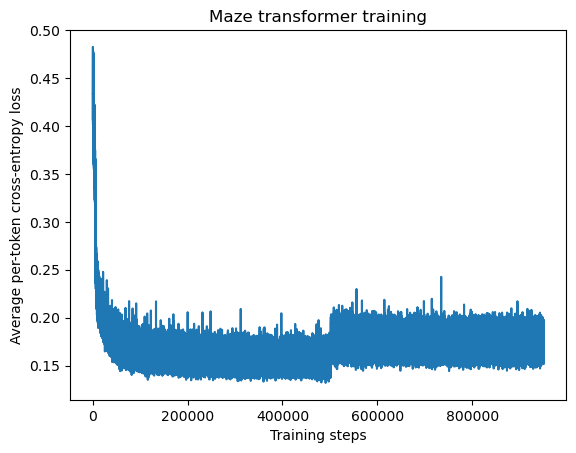

In [7]:
print(len(losses))

plt.plot(losses)
#plt.yscale('log')
#plt.xscale('log')
plt.title('Maze transformer training')
plt.xlabel('Training steps')
plt.ylabel('Average per-token cross-entropy loss')
plt.savefig('maze_transformer_training.pdf')

print(np.mean(losses[-100:]))

In [8]:
#@jax.jit
def optimal_pred_loss_fn(batch):

    path_len = batch['true_preds'].shape[1]
    true_preds = batch['true_preds']
    assert true_preds.shape == (batch_size, path_len, dataset.vocab_size)
    
    targets = batch['data']

    pred_loss = 0
    n = 0

    last_step = np.zeros((1,dataset.vocab_size))
    last_step[0,7] = 1.

    for i, (sample, true_pred) in enumerate(zip(batch['data'],true_preds)):
        target = sample[batch['start_index'][i]+1:batch['end_index'][i]+1]
        pred = jnp.concatenate([true_pred[:1+batch['true_preds_end_index'][i]], last_step], axis=0)
        #print(pred)
        #print(target)
        loss = optax.softmax_cross_entropy_with_integer_labels(
        logits = jnp.log(pred),
        labels = target
        )
        pred_loss += loss.sum()
        n+=target.shape[0]

    return pred_loss/n

In [9]:
# to start with, get an estimate of optimal loss, and of loss of our model, for the no loops case

dataset = CustomMazeDataset(include_maze=False,no_loops=True)
train_loader_iter = iter(NumpyLoader(dataset, batch_size=batch_size, num_workers=n_worker))

model_loss = []
optimal_loss = []

for n in range(10):
    batch = next(train_loader_iter)
    loss = optimal_pred_loss_fn(batch)
    optimal_loss.append(loss)
    loss = loss_fn(state['params'],batch)
    model_loss.append(loss)


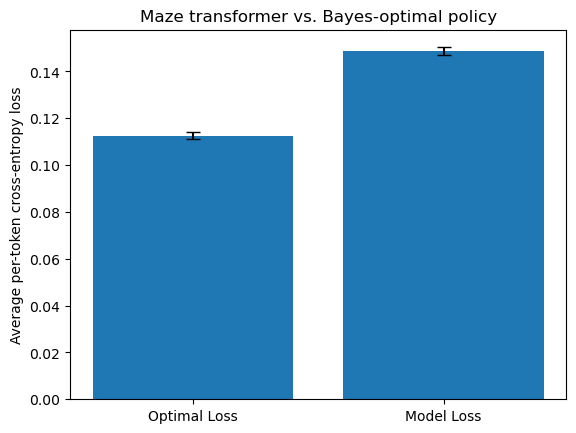

In [10]:

categories = ['Optimal Loss', 'Model Loss']
values = [np.mean(optimal_loss), np.mean(model_loss)]  # Example values for optimal loss and model loss
errors = [np.std(optimal_loss)/np.sqrt(len(optimal_loss)), np.std(model_loss)/np.sqrt(len(model_loss))]  # Calculating standard errors

# Creating a bar plot with error bars
plt.bar(categories, values, yerr=errors, capsize=5)

# Adding labels
plt.ylabel('Average per-token cross-entropy loss')
plt.title('Maze transformer vs. Bayes-optimal policy')

# Display the plot

plt.savefig('optimal_vs_model.pdf')
plt.show()

In [11]:
# Chat GPT generated

def is_valid_path(maze, path, start_pos):
    """
    Checks if the given path is valid in the maze.
    
    Args:
    maze (list[list[list[bool]]]): The maze as a 3D list where maze[z][y][x] is True if the cell at (x, y) is connected
                                    to the cell at (x + 1, y) (if z == 0) or (x, y + 1) (if z == 1).
    path (list[tuple[int, int]]): The path through the maze as a list of (x, y) coordinates.

    Returns:
    bool: True if the path is valid, False otherwise.
    """
    rows, cols = len(maze[0]), len(maze[0][0])

    #print(maze)
    #print(path)
    #print(start_pos)

    if not path[-1] in [(0,0),(0,4),(4,0),(4,4)]:
        return False
    if not path[0] == start_pos:
        return False

    for i in range(len(path) - 1):
        x1, y1 = path[i]
        x2, y2 = path[i + 1]
        #print(f'looking at {x1,y1,x2,y2}')

        # Check if the path goes out of maze bounds
        if not (0 <= x1 < cols and 0 <= y1 < rows and 0 <= x2 < cols and 0 <= y2 < rows):
            return False

        # Check if the path is a valid move
        if x1 + 1 == x2 and y1 == y2:  # Move down
            if not maze[0][x1][y1]:
                return False
        elif x1 == x2 and y1 + 1 == y2:  # Move right
            if not maze[1][x1][y1]:
                return False
        elif x1 == x2 + 1 and y1 == y2:  # Move up
            if not maze[0][x2][y2]:
                return False
        elif x1 == x2 and y1 == y2 +1:  # Move left
            if not maze[1][x2][y2]:
                return False
        else:  # Invalid move
            return False

    return True

In [12]:
# Chat GPT generated

from collections import deque

def bfs_shortest_path_length(maze, start, end):
    """
    Finds the length of the shortest path in the maze using BFS.

    Args:
    maze (list[list[list[bool]]]): The maze as a 3D list.
    start, end (tuple[int, int]): The starting and ending coordinates in the maze.

    Returns:
    int: The length of the shortest path. -1 if no path exists.
    """
    rows, cols = len(maze[0]), len(maze[0][0])
    queue = deque([(start, 0)])  # (position, distance)
    visited = set([start])

    while queue:
        (x, y), dist = queue.popleft()

        # Check if we've reached the end
        if (x, y) == end:
            return dist

        # Check possible moves
        # down
        if x + 1 < cols and maze[0][x][y] and (x + 1, y) not in visited:
            visited.add((x + 1, y))
            queue.append(((x + 1, y), dist + 1))

        # right
        if y + 1 < rows and maze[1][x][y] and (x, y + 1) not in visited:
            visited.add((x, y + 1))
            queue.append(((x, y + 1), dist + 1))

        # up
        if x - 1 >= 0 and maze[0][x-1][y] and (x - 1, y) not in visited:
            visited.add((x-1, y))
            queue.append(((x-1, y), dist + 1))

        # left
        if y - 1 >= 0 and maze[1][x][y-1] and (x, y - 1) not in visited:
            visited.add((x, y - 1))
            queue.append(((x, y - 1), dist + 1))

    return -1  # No path found


In [46]:
dataset = CustomMazeDataset(include_maze=True, no_loops=False)
train_loader_iter = iter(NumpyLoader(dataset, batch_size=batch_size, num_workers=0))
batch = next(train_loader_iter)

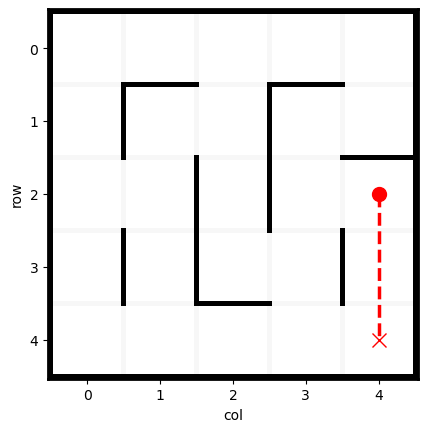

[[[ True False  True False  True]
  [ True  True  True  True False]
  [ True  True  True  True  True]
  [ True  True False  True  True]
  [False False False False False]]

 [[ True  True  True  True False]
  [False  True False  True False]
  [ True False False  True False]
  [False False  True False False]
  [ True  True  True  True False]]]
[(3, 0), (4, 0)]
False
True
[(4, 0)]
False
True
[(3, 0), (3, 1), (4, 1), (4, 0)]
False
False
[(3, 0), (2, 0), (1, 0), (0, 0)]
False
True
[(3, 0), (2, 0), (1, 0), (2, 0), (3, 0), (4, 0)]
False
False
[(0, 0), (0, 1), (1, 1), (1, 0), (0, 0)]
False
False


In [60]:
# debug implementation

plot = MazePlot(batch['maze'][0])
plot.plot()
plt.show()
connection_list = batch['maze'][0].connection_list
# check some paths
print(connection_list)

paths = [
    [(3,0),(4,0)],
    [(4,0)],
    [(3,0),(3,1),(4,1),(4,0)],
    [(3,0),(2,0),(1,0),(0,0)],
    [(3,0),(2,0),(1,0),(2,0),(3,0),(4,0)],
    [(0,0),(0,1),(1,1),(1,0),(0,0)]
]

for path in paths:

    start_pos = (0,2)
    print(path)
    print(is_valid_path(connection_list, path, start_pos))
    print(bfs_shortest_path_length(connection_list,path[0],path[-1])==len(path)-1)

 batch no 0
maze no 0
maze no 1
maze no 2
maze no 3
maze no 4
maze no 5
maze no 6
maze no 7
maze no 8
maze no 9
maze no 10
maze no 11
maze no 12
maze no 13
maze no 14
maze no 15
maze no 16
maze no 17
maze no 18
maze no 19
maze no 20
maze no 21
maze no 22
maze no 23
maze no 24
maze no 25
maze no 26
maze no 27
maze no 28
maze no 29
maze no 30
maze no 31
maze no 32
maze no 33
maze no 34
maze no 35
maze no 36
maze no 37
maze no 38
maze no 39
maze no 40
maze no 41
maze no 42
maze no 43
maze no 44
maze no 45
maze no 46
maze no 47
maze no 48
maze no 49
maze no 50
maze no 51
maze no 52
maze no 53
maze no 54
maze no 55
maze no 56
maze no 57
maze no 58
maze no 59
maze no 60
maze no 61
maze no 62
maze no 63
maze no 64
maze no 65
maze no 66
maze no 67
maze no 68
maze no 69
maze no 70
maze no 71
maze no 72
maze no 73
maze no 74
maze no 75
maze no 76
maze no 77
maze no 78
maze no 79
maze no 80
maze no 81
maze no 82
maze no 83
maze no 84
maze no 85
maze no 86
maze no 87
maze no 88
maze no 89
maze no 

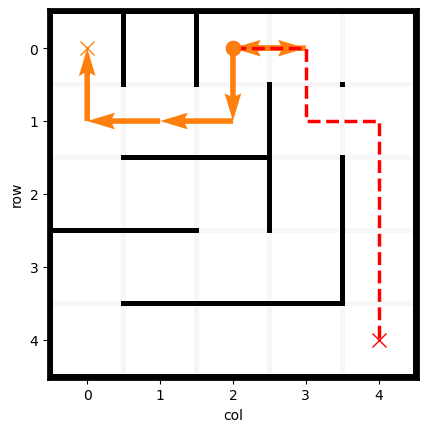

maze no 127
 batch no 2
maze no 0
maze no 1
maze no 2
maze no 3
maze no 4
maze no 5
maze no 6
maze no 7
maze no 8
maze no 9
maze no 10
maze no 11
maze no 12
maze no 13
maze no 14
maze no 15
maze no 16
maze no 17
maze no 18
maze no 19
maze no 20
maze no 21
maze no 22
maze no 23
maze no 24
maze no 25
maze no 26
maze no 27
maze no 28
maze no 29
maze no 30
maze no 31
maze no 32
maze no 33
maze no 34
maze no 35
maze no 36
maze no 37
maze no 38
maze no 39
maze no 40
maze no 41
maze no 42
maze no 43
maze no 44
maze no 45
maze no 46
maze no 47
maze no 48
maze no 49
maze no 50
maze no 51
maze no 52
maze no 53
maze no 54
maze no 55
maze no 56
maze no 57
maze no 58
maze no 59
maze no 60
maze no 61
maze no 62
maze no 63
maze no 64
maze no 65
maze no 66
maze no 67
maze no 68
maze no 69
maze no 70
maze no 71
maze no 72
maze no 73
maze no 74
maze no 75
maze no 76
maze no 77
maze no 78
maze no 79
maze no 80
maze no 81
maze no 82
maze no 83
maze no 84
maze no 85
maze no 86
maze no 87
maze no 88
maze no

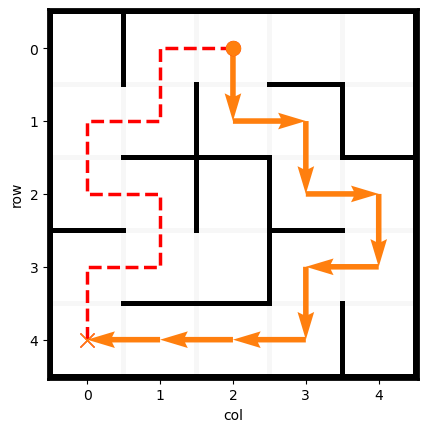

maze no 94
maze no 95
maze no 96
maze no 97
maze no 98
maze no 99
maze no 100
maze no 101
maze no 102
maze no 103
maze no 104
maze no 105
maze no 106
maze no 107
maze no 108
maze no 109
maze no 110
maze no 111
maze no 112
maze no 113
maze no 114
maze no 115
maze no 116
maze no 117
maze no 118
maze no 119
maze no 120
maze no 121
maze no 122
maze no 123
maze no 124
maze no 125
maze no 126
maze no 127
 batch no 3
maze no 0
maze no 1
maze no 2
maze no 3
maze no 4
maze no 5
maze no 6
maze no 7
maze no 8
maze no 9
maze no 10
maze no 11
maze no 12
maze no 13
maze no 14
maze no 15
maze no 16
maze no 17
maze no 18
maze no 19
maze no 20
maze no 21
maze no 22
maze no 23
maze no 24
maze no 25
maze no 26
maze no 27
maze no 28
maze no 29
maze no 30
maze no 31
maze no 32
maze no 33
maze no 34
maze no 35
maze no 36
maze no 37
maze no 38
maze no 39
maze no 40
maze no 41
maze no 42
maze no 43
maze no 44
maze no 45
maze no 46
maze no 47
maze no 48
maze no 49
maze no 50
maze no 51
maze no 52
maze no 53
ma

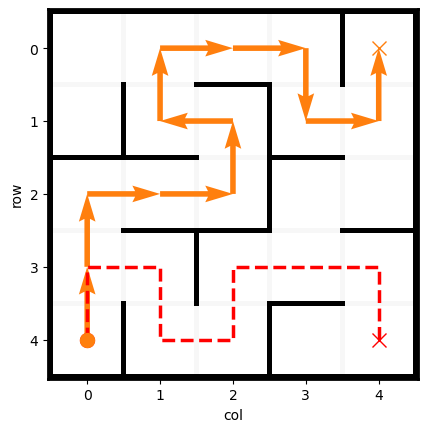

maze no 65
maze no 66
maze no 67
maze no 68
maze no 69
maze no 70
maze no 71
maze no 72
maze no 73
maze no 74
maze no 75
maze no 76
maze no 77
maze no 78
maze no 79
maze no 80
maze no 81
maze no 82
maze no 83
maze no 84
maze no 85
maze no 86
maze no 87
maze no 88
maze no 89
maze no 90
maze no 91
maze no 92
maze no 93
maze no 94
maze no 95
maze no 96
maze no 97
maze no 98
maze no 99
maze no 100
maze no 101
maze no 102
maze no 103
maze no 104
maze no 105
maze no 106
maze no 107
maze no 108
maze no 109
maze no 110
maze no 111
maze no 112
maze no 113
maze no 114
maze no 115
maze no 116
maze no 117
maze no 118
maze no 119
maze no 120
maze no 121
maze no 122
maze no 123
maze no 124
maze no 125
maze no 126
maze no 127
 batch no 5
maze no 0
maze no 1
maze no 2
maze no 3
maze no 4
maze no 5
maze no 6
maze no 7
maze no 8
maze no 9
maze no 10
maze no 11
maze no 12
maze no 13
maze no 14
maze no 15
maze no 16
maze no 17
maze no 18
maze no 19
maze no 20
maze no 21
maze no 22
maze no 23
maze no 24
ma

In [74]:
n_test_batches = 10

# this is for checking whether the model produces valid paths, and what the distribution over paths lengths is

# couldn't be bothered to implement batched inference, so this takes ages

corner_stats = [0]*4
path_valid = []
path_shortest = []
path_length = []
path_distance = []

data_path_length = []
data_path_distance = []

key = random.PRNGKey(0)

for no in range(n_test_batches):
    print(f' batch no {no}')
    batch = next(train_loader_iter)
    for maze_num in range(batch_size):
        print(f'maze no {maze_num}')
    
        start_pos = reverse_map[batch['data'][maze_num,batch['start_index'][maze_num]+1]]
        start_pos = (int(start_pos[1]), int(start_pos[3]))
    
        model_gen = []
    
        prompt = list(batch['data'][maze_num][:batch['start_index'][maze_num]+1])
    
        t=0
    
        for t in range(25):

            # pad to avoid unnecessary jit compiles
            input = prompt + model_gen

            final_pos = len(input) - 1

            input = input + [0]*(256-final_pos-1)
            assert len(input)==256
            
            input = jnp.array(input)[None,:]
            
            pred, act = jax.jit(model.apply)(state['params'],input)
            
            rng, key = random.split(key)
            sample = random.categorical(rng, pred[0][final_pos])
    
            model_gen.append(int(sample))
    
            if model_gen[-1]==vocab_map('<PATH_END>'):
                break
    
        curr_maze = batch['maze'][maze_num]
        path = [(int(s[1]),int(s[3])) for s in [reverse_map[k] for k in model_gen[:-1]]]
        connection_list = curr_maze.connection_list
    
        is_valid = is_valid_path(connection_list, path, start_pos)
        path_valid.append(is_valid)
        if is_valid:

            path_length.append(len(path)-1)
            data_path_length.append(batch['end_index'][maze_num]-batch['start_index'][maze_num]-2)
            
            start = reverse_map[int(batch['data'][maze_num][batch['start_index'][maze_num]+1])]
            goal = reverse_map[int(batch['data'][maze_num][batch['end_index'][maze_num]-1])]
            
            start = (int(start[1]),int(start[3]))
            goal = (int(goal[1]),int(goal[3]))
                
            data_path_distance.append(abs(start[0]-goal[0])+abs(start[1]-goal[1]))
            
            
            path_distance.append(abs(path[0][0]-path[-1][0])+abs(path[0][1]-path[-1][1]))
        
    
            shortest_len = bfs_shortest_path_length(connection_list, path[0], path[-1])
            assert shortest_len <= len(path)-1 or not is_valid 
            is_shortest = shortest_len == len(path)-1

            
            corner_stats[target_dict[model_gen[-2]]]+=1
        
            path_shortest.append(is_shortest)

            if not is_shortest:
                print('not shortest!!')
                # display maze
                print(connection_list)
                print(start_pos)
                print(path)

                plot = MazePlot(curr_maze)
                path = ints_to_coords(model_gen)
                plot.add_predicted_path(path)
                plot.plot()
            
                print(maze_num)
                plt.show()

            
        else:

            print('not valid!!')
            # display maze
            plot = MazePlot(curr_maze)
            path = ints_to_coords(model_gen)
            plot.add_predicted_path(path)
            plot.plot()
        
            print(maze_num)
            plt.show()
        

In [137]:
print('\ncorner statistics:')
print(corner_stats)
print(f'total: {np.sum(corner_stats)}')
print([(reverse_map[corner], p) for corner, p in zip(target_dict.keys(), np.array(corner_stats)/np.sum(corner_stats))])

from scipy.stats import chisquare

# Given values
p = [0.25, 0.25, 0.25, 0.25]  # Probabilities for each outcome
n = np.sum(corner_stats)  # Total number of trials

# Expected frequencies
expected = [n * pi for pi in p]

# Perform the chi-square test
chi2_stat, p_value = chisquare(corner_stats, f_exp=expected)

print(f'chi-square p value: {p_value}')

valid_percent = np.mean(path_valid)
print(f'\nvalid path percentage: {valid_percent}')
print(1280-np.sum(path_valid))


shortest_percent = np.mean(path_shortest)
print(f'\nshortest path percentage: {shortest_percent}')
print(1280-np.sum(path_shortest))


corner statistics:
[321, 319, 289, 351]
total: 1280
[('(0,0)', 0.25078125), ('(0,4)', 0.24921875), ('(4,0)', 0.22578125), ('(4,4)', 0.27421875)]
chi-square p value: 0.11100365413061558

valid path percentage: 1.0
0

shortest path percentage: 0.99765625
3


In [ ]:
# path statistics:
#print(path)
#print(batch['data'][0][batch['start_index'][0]:])
#print(path_length)
#print(data_path_length)

from matplotlib.ticker import MaxNLocator

for i, measure in enumerate([(path_length, data_path_length, 'L1 path length'), 
                             (path_distance, data_path_distance, 'L1 distance to goal')]):

    print('testing ' + measure[2])
    
    obs_frequencies = [0 for _ in range(25)]
    exp_frequencies = [0 for _ in range(25)]
    
    for n in measure[0]:
        obs_frequencies[n] += 1
    for n in measure[1]:
        exp_frequencies[n] += 1

    while obs_frequencies[-1] == exp_frequencies[-1] == 0:
        obs_frequencies.pop()
        exp_frequencies.pop()

    if measure[2] == 'L1 path length':
        #I'm summing up the highest values since there are too few of them
        obs_frequencies[18] = sum(obs_frequencies[18:])
        exp_frequencies[18] = sum(exp_frequencies[18:])
    
        obs_frequencies = obs_frequencies[:19]
        exp_frequencies = exp_frequencies[:19]

    print(obs_frequencies)
    print(exp_frequencies)
    
    # Perform the chi-square test
    chi2_stat, p_value = chisquare(obs_frequencies, f_exp=exp_frequencies)
    print(f'chi-square p value: {p_value}')
    
    # Create a new figure for each plot
    plt.figure()
    
    # Plotting
    plt.hist(measure[0], bins=np.arange(len(obs_frequencies)+1)-0.5, alpha=0.7, label='Model generations')
    plt.hist(measure[1], bins=np.arange(len(obs_frequencies)+1)-0.5, alpha=0.7, label='Dataset')
    plt.legend()
    plt.title(f'{measure[2]}')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('Count')

    # Save each plot as a separate file
    plt.savefig(f'{measure[2].replace(" ", "_")}_stats.pdf')

In [ ]:
class LinearProbe(nn.Module):

  @nn.compact
  def __call__(self, x):
    # input should be batch_size x n_layers (one probe per layer) x emb_dim
    #y = nn.Dense(features=128)(x)
    #y = nn.relu(y)
    #y = nn.Dense(features=64)(x)
    #y = nn.relu(y)
    # treat the layers as 1 D spatial dimension, the model dim as channel dim
    bs = x.shape[0]
    #print(x.shape)
    #W_in = self.param('W', nn.initializers.xavier_uniform(), (num_layers+1, emb_dim, emb_dim))
    W_out = self.param('W', nn.initializers.xavier_uniform(), (num_layers+1, emb_dim, 4))
    b = self.param('b', nn.initializers.zeros, (num_layers+1, 4))
    assert x.shape == (bs, num_layers+1, emb_dim)
    x = nn.LayerNorm(reduction_axes=2, feature_axes=(1,2))(x)
    #y = einsum(W_in, x, 'l m h, bs l m -> bs l h')
    #y = nn.relu(y)
    y = einsum(W_out, x, 'l m o, bs l m -> bs l o')
    return y + b

#def concat_acts(act, first_layer, last_layer):
#  assert len(act['stream'])>=last_layer
#  stream = act['stream'][first_layer:last_layer+1]
#  #concat along model dim (i.e. keep batch and sequence positions separate)
# acts = jnp.concatenate(stream,axis=-1)
#  #print(acts.shape)
#  #acts = acts[:,:,:]
#  #print(acts.shape)
#  return acts

def prepare_acts(act):
    assert act['stream'][0].shape[0] == batch_size, act['stream'][0].shape[2] == emb_dim
    seq_len = act['stream'][0].shape[1]
    # note: input has dimensions n_layer x batch_size x sequence_len x emb_dim
    
    acts  = rearrange(act['stream'], 'layer bs seq dim -> (bs seq) layer dim')

    
    # return a tensor in which all seq positions are in one big batch, then layer, then model dim
    assert len(acts.shape)==3
    assert acts.shape == (batch_size * seq_len, num_layers+1, emb_dim)

    return acts, seq_len

In [ ]:
# Linear probe training

# Start a new experiment


losses = []
eval_losses = []

#batch = next(iter(train_loader))


key = random.PRNGKey(0)

rng, key = random.split(key)


#print(f'default loss: {jnp.log()}')

pred, act = model.apply(state['params'], batch['data'])

acts, seq_len = prepare_acts(act) # this is just to initialize the probe, so take first sequence position arbitrarily

x = acts

probe = LinearProbe()

tx = optax.adamw(3e-4)

params = probe.init(rng, x)

opt_state = tx.init(params)

probe_state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}

target_dict = {
      11: 0,
      27: 1,
      29: 2,
      35: 3
  }

@functools.partial(jax.jit, static_argnums=(2,))
def probe_loss_fn(params, batch, reduce_layers = 1):
  pred, act = model.apply(state['params'], batch['data'])
      
  acts, seq_len = prepare_acts(act)
  assert seq_len == batch['data'].shape[1]

  targets = batch['data'][jnp.arange(0,pred.shape[0]),batch['end_index']-1]

  #print(targets)

  new_targets = targets.copy()

  for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

  #print(new_targets)
  # expanding targets along seq len (result is shape 
  repeated_targets = jnp.repeat(new_targets, seq_len, axis = 0)
  assert repeated_targets.shape == (seq_len * batch_size,)
  repeated_targets = jnp.repeat(repeated_targets[:,None], num_layers+1, axis=1)
  assert repeated_targets.shape == (seq_len * batch_size,num_layers+1)
  

  probe_pred = probe.apply(params, acts)

  # probe preds are of shape (batch_size * seq_len, num_layer, 4)

  assert repeated_targets.shape == probe_pred.shape[:-1]

  assert len(repeated_targets.shape)==2

  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits = probe_pred,
      labels = repeated_targets
  )

  # loss is of shape (batch_size * seq_len, num_layer). First, undo the reshaping.

  loss = rearrange(loss, '(bs seq) layer -> bs seq layer', bs=batch_size, seq=seq_len, layer=num_layers+1)
  
  idx = jnp.arange(seq_len)[None, :]

  mask = jnp.where((idx < batch['end_index'][:, None]) & (idx > batch['start_index'][:, None]), 1., 0.)

  # need to broadcast mask over the last layer dimension
  assert mask.shape == (batch_size,seq_len)
  loss = loss * mask[:,:,None]

  if reduce_layers:
      # just add up losses over all the layers. that's fine.
      loss = loss.sum() / mask.sum()
  else:
      loss = loss.sum(axis=(0,1))/mask.sum()

  return loss

@jax.jit
def probe_train_step(probe_state,batch):
  params = probe_state['params']
  opt_state = probe_state['opt_state']
  loss, grads = jax.value_and_grad(probe_loss_fn)(params,batch)
  updates, opt_state = tx.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  step = probe_state['step'] + 1

  return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

@jax.jit
def probe_eval_step(state,batch):
  params = state['params']
  loss = probe_loss_fn(params,batch)
  return loss

probe_losses = []
probe_eval_losses = []


In [ ]:
#@jax.jit
def optimal_loss_fn(batch):

    path_len = batch['true_probs'].shape[1]
    true_probs = batch['true_probs']
    assert true_probs.shape == (batch_size, path_len, 4)
    
    targets = batch['data'][jnp.arange(0,batch['data'].shape[0]),batch['end_index']-1]
    new_targets = targets.copy()
    
    for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

    #print(new_targets)
    # expanding targets along seq len (result is shape 
    repeated_targets = jnp.repeat(new_targets, path_len, axis = 0)
    assert repeated_targets.shape == (path_len * batch_size,)

    true_probs_reshaped = rearrange(true_probs, 'bs seq i -> (bs seq) i')
    assert true_probs_reshaped.shape == (path_len * batch_size, 4)

    log_probs = jnp.log(true_probs_reshaped)

    #print(log_probs[:10])
    #print(repeated_targets[:10])

    loss = optax.softmax_cross_entropy_with_integer_labels(
          logits = log_probs,
          labels = repeated_targets
      )
    #print(loss[:10])
    
    # loss is of shape (batch_size * seq_len). First, undo the reshaping.
    
    loss = rearrange(loss, '(bs seq) -> bs seq ', bs=batch_size, seq=path_len)
    
    idx = jnp.arange(path_len)[None, :]
    
    mask = jnp.where((idx <= batch['true_probs_end_index'][:, None]), 1., 0.)
    
    assert mask.shape == (batch_size,path_len)
    loss = np.ma.array(loss, mask=1-mask)
    #print(loss[:10])

    loss = loss.mean()
    
    return loss

In [ ]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
probe_options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=keep_n_checkpoints)
probe_checkpoint_manager = orbax.checkpoint.CheckpointManager(os.path.join(base_path,'probe_layernorm_bias'), orbax_checkpointer, probe_options)

In [ ]:
# PROBE LOADING


dummy_dict = {
            'probe_state': probe_state,
            'probe_loss': np.zeros(1)}

step = probe_checkpoint_manager.latest_step()
print(f'loading step {step}')
load_dict = probe_checkpoint_manager.restore(step, items=dummy_dict)
probe_state = load_dict['probe_state']
probe_losses = list(load_dict['probe_loss'])
print(np.mean(probe_losses[-100:]))

# Probe training

In [ ]:
dataset = CustomMazeDataset(include_maze=False, no_loops=False)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=n_worker)

In [ ]:
loop_time = time.time()

for n, batch in enumerate(train_loader):
    # do the actual training

    probe_state = probe_train_step(probe_state, batch)
    
    probe_losses.append(probe_state['loss'])
    
    print(f'step: {probe_state["step"]}')
    print('loss: {}'.format(probe_state['loss']))
    old_time = loop_time
    loop_time = time.time()
    print('steps per second: {:.5f}'.format(1/(loop_time - old_time)))

    

    if n % 100 == 0:
        print('\n\n----- saving and eval -----')
        #optimal_loss = optimal_loss_fn(batch)
        #print(f'optimal_loss: {optimal_loss}')
        layer_losses = probe_loss_fn(probe_state['params'],batch,reduce_layers=False)
        layer, best_layer_loss = layer_losses.argmin(), layer_losses.min()
        print(f'best layer loss: {best_layer_loss}, layer: {layer}')
        probe_save_step = probe_state['step']
        print(f'saving at step {probe_save_step}')
        probe_save_dict = {'probe_state': probe_state,
                     'probe_loss': np.array(probe_losses)
                     }
        probe_save_args = orbax_utils.save_args_from_target(probe_save_dict)
        probe_checkpoint_manager.save(probe_save_step, probe_save_dict, save_kwargs={'save_args': probe_save_args})
        print('----------\n\n')
    

# note that completely oblivious loss is 1.3862944 for 4 options (since dataset is uniformly random)

In [ ]:
# PROBE SAVING
probe_save_step = probe_state['step']
print(f'saving at step {probe_save_step}')
probe_save_dict = {'probe_state': probe_state,
             'probe_loss': np.array(probe_losses)
             }
probe_save_args = orbax_utils.save_args_from_target(probe_save_dict)
probe_checkpoint_manager.save(probe_save_step, probe_save_dict, save_kwargs={'save_args': probe_save_args})

# Baseline setup

In [ ]:
embeddings = jnp.array(state['params']['params']['decoder']['Embed_0']['embedding'])

def get_baseline_features(data):
    # Baseline features:
    # for simplicity, we just concatenate the embeddings of the past two tokens.
    data = jnp.array(data)
    features = embeddings[data]

    two_step_features = jnp.concatenate([features[:,:-1,:],features[:,1:,:]],axis=-1)
    seq_len = two_step_features.shape[1]
    out = rearrange(two_step_features, 'bs seq feat -> (bs seq) feat')

    return out, seq_len
    

n_baseline_probe_layers = 1
n_hidden = emb_dim

class BaselineProbe(nn.Module):
    @nn.compact
    def __call__(self, x):
        for layer in range(n_baseline_probe_layers):
            x = nn.Dense(n_hidden)(x)
            x = nn.relu(x)
        out = nn.Dense(4)(x)
        return out

In [ ]:


# Start a new experiment

losses = []
eval_losses = []

#batch = next(iter(train_loader))


key = random.PRNGKey(0)

rng, key = random.split(key)

baseline_probe = BaselineProbe()

x, seq_len = get_baseline_features(batch['data'])

tx = optax.adamw(1e-4)

params = baseline_probe.init(rng, x)

opt_state = tx.init(params)

baseline_state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}

@jax.jit
def baseline_loss_fn(params, batch):
  inputs, seq_len = get_baseline_features(batch['data'])
      
  assert seq_len == batch['data'].shape[1] - 1

  targets = batch['data'][jnp.arange(0,batch_size),batch['end_index']-1]

  new_targets = targets.copy()

  for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

  #print(new_targets)
  # expanding targets along seq len (result is shape 
  repeated_targets = jnp.repeat(new_targets, seq_len, axis = 0)
  assert repeated_targets.shape == (seq_len * batch_size,)

  probe_pred = baseline_probe.apply(params, inputs)

  assert repeated_targets.shape == probe_pred.shape[:-1]

  assert len(repeated_targets.shape)==1

  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits = probe_pred,
      labels = repeated_targets
  )

  # loss is of shape (batch_size * seq_len, num_layer). First, undo the reshaping.

  loss = rearrange(loss, '(bs seq) -> bs seq', bs=batch_size, seq=seq_len)
  
  idx = jnp.arange(seq_len)[None, :]

  mask = jnp.where((idx < batch['end_index'][:, None]-1) & (idx > batch['start_index'][:, None]-1), 1., 0.)

  # need to broadcast mask over the last layer dimension
  assert mask.shape == (batch_size,seq_len)
  loss = loss * mask
  loss = loss.sum()/mask.sum()

  return loss

@jax.jit
def baseline_train_step(baseline_state,batch):
  params = baseline_state['params']
  opt_state = baseline_state['opt_state']
  loss, grads = jax.value_and_grad(baseline_loss_fn)(params,batch)
  updates, opt_state = tx.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  step = baseline_state['step'] + 1

  return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

baseline_losses = []


In [ ]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
baseline_options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=1000)
baseline_checkpoint_manager = orbax.checkpoint.CheckpointManager(os.path.join(base_path,'baseline_probe_1hidden_loops'), orbax_checkpointer, baseline_options)

In [ ]:
# BASELINE PROBE LOADING
dummy_dict = {
            'baseline_state': baseline_state,
            'baseline_loss': np.zeros(1)}

step = baseline_checkpoint_manager.latest_step()
print(f'loading step {step}')
load_dict = baseline_checkpoint_manager.restore(step, items=dummy_dict)
baseline_state = load_dict['baseline_state']
baseline_losses = list(load_dict['baseline_loss'])
print(np.mean(baseline_losses[-100:]))

# Probe analysis

In [ ]:
print(len(probe_losses))
print(np.mean(probe_losses[-100:]))

#plt.plot(old_probe_losses)
plt.plot(probe_losses)
#plt.xscale('log')
#plt.yscale('log')
plt.title('Probe training (losses summed over all layers)')
plt.xlabel('Training steps')
plt.ylabel('Average cross-entropy loss')
plt.savefig('probe_training.pdf')

In [ ]:
#@jax.jit
def optimal_loss_fn(batch):

    path_len = batch['true_probs'].shape[1]
    true_probs = batch['true_probs']
    assert true_probs.shape == (batch_size, path_len, 4)
    
    targets = batch['data'][jnp.arange(0,batch['data'].shape[0]),batch['end_index']-1]
    new_targets = targets.copy()
    
    for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

    #print(new_targets)
    # expanding targets along seq len (result is shape 
    repeated_targets = jnp.repeat(new_targets, path_len, axis = 0)
    assert repeated_targets.shape == (path_len * batch_size,)

    true_probs_reshaped = rearrange(true_probs, 'bs seq i -> (bs seq) i')
    assert true_probs_reshaped.shape == (path_len * batch_size, 4)

    log_probs = jnp.log(true_probs_reshaped)

    #print(log_probs[:10])
    #print(repeated_targets[:10])

    loss = optax.softmax_cross_entropy_with_integer_labels(
          logits = log_probs,
          labels = repeated_targets
      )
    #print(loss[:10])
    
    # loss is of shape (batch_size * seq_len). First, undo the reshaping.
    
    loss = rearrange(loss, '(bs seq) -> bs seq ', bs=batch_size, seq=path_len)
    
    idx = jnp.arange(path_len)[None, :]
    
    mask = jnp.where((idx <= batch['true_probs_end_index'][:, None]), 1., 0.)
    
    assert mask.shape == (batch_size,path_len)
    loss = np.ma.array(loss, mask=1-mask)
    #print(loss[:10])

    loss = loss.mean()
    
    return loss

In [ ]:
# Now get an estimate of optimal loss, and probe losses for all layers, and baseline 

dataset = CustomMazeDataset(include_maze=False,no_loops=True)
train_loader_iter = iter(NumpyLoader(dataset, batch_size=batch_size, num_workers=n_worker))

probe_loss = {i: [] for i in range(13)}
optimal_loss = []
baseline_loss = []

for n in range(10):
    batch = next(train_loader_iter)
    loss = optimal_loss_fn(batch)
    optimal_loss.append(loss)
    loss = probe_loss_fn(probe_state['params'],batch, reduce_layers=False)
    for i in range(13):
        probe_loss[i].append(loss[i])
    loss = baseline_loss_fn(baseline_state['params'], batch)
    baseline_loss.append(loss)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean values for the horizontal lines
optimal_loss_value = np.mean(optimal_loss)
baseline_loss_value = np.mean(baseline_loss)

# Sample data for the bar plot
categories = [f'{i}' for i in range(13)]
values = [np.mean(probe_loss[i]) for i in range(13)] 

# Adding the horizontal lines with labels
plt.axhline(optimal_loss_value, color='green', linestyle='--', label='Optimal Loss')
plt.axhline(baseline_loss_value, color='red', linestyle='--', label='Baseline Loss')

# Creating a bar plot
plt.bar(categories, values)

# Adding labels and title
plt.ylabel('Average Cross-Entropy Loss')
plt.title('Losses for Probes on Different Layers')

# Add a legend to the plot
plt.legend()

# Display the plot and save the figure

plt.savefig('probes_different_layers_baseline.pdf')
plt.show()